### 1. Load molecule

Make sure to install RDKit before running this example notebook:

```
conda install -c conda-forge rdkit
```

In [1]:
from qdk.chemistry import Molecule

In [2]:
caffeine = Molecule.from_xyz("data/xyz/caffeine.xyz")

In [3]:
caffeine

JsmolWidget(layout=Layout(align_self='stretch', height='400px'))

In [4]:
with open("data/xyz/caffeine.xyz", "r") as f:
    print(f.read())

24
Caffeine
H      -3.3804130    -1.1272367     0.5733036
N       0.9668296    -1.0737425    -0.8198227
C       0.0567293     0.8527195     0.3923156
N      -1.3751742    -1.0212243    -0.0570552
C      -1.2615018     0.2590713     0.5234135
C      -0.3068337    -1.6836331    -0.7169344
C       1.1394235     0.1874122    -0.2700900
N       0.5602627     2.0839095     0.8251589
O      -0.4926797    -2.8180554    -1.2094732
C      -2.6328073    -1.7303959    -0.0060953
O      -2.2301338     0.7988624     1.0899730
H       2.5496990     2.9734977     0.6229590
C       2.0527432    -1.7360887    -1.4931279
H      -2.4807715    -2.7269528     0.4882631
H      -3.0089039    -1.9025254    -1.0498023
H       2.9176101    -1.8481516    -0.7857866
H       2.3787863    -1.1211917    -2.3743655
H       1.7189877    -2.7489920    -1.8439205
C      -0.1518450     3.0970046     1.5348347
C       1.8934096     2.1181245     0.4193193
N       2.2861252     0.9968439    -0.2440298
H      -0.1687028     

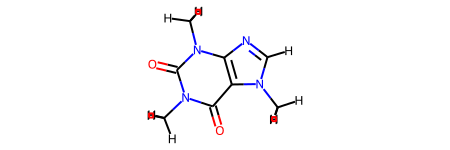

In [5]:
caffeine.mol

In [6]:
type(caffeine.mol)

rdkit.Chem.rdchem.Mol

In [7]:
caffeine.smiles

'[H]Cn1c(=O)c2c(ncn2C)n(C)c1=O'

In [8]:
caffeine.num_electrons

102

In [9]:
caffeine.atoms

[1, 6, 7, 8]

### 2. Load Broombridge and simulate in Q#

In [10]:
%%writefile RPE.qs
namespace Microsoft.Quantum.Chemistry.RPE {
    open Microsoft.Quantum.Core;
    open Microsoft.Quantum.Intrinsic;
    open Microsoft.Quantum.Canon;
    open Microsoft.Quantum.Chemistry;
    open Microsoft.Quantum.Chemistry.JordanWigner;  
    open Microsoft.Quantum.Simulation;
    open Microsoft.Quantum.Characterization;
    open Microsoft.Quantum.Convert;
    open Microsoft.Quantum.Math;

    operation GetEnergyRPE (
        JWEncodedData: JordanWignerEncodingData,
        nBitsPrecision : Int, 
        trotterStepSize : Double, 
        trotterOrder : Int
    ) : (Double, Double) {

        let (nSpinOrbitals, fermionTermData, inputState, energyOffset) = JWEncodedData!;
        let (nQubits, (rescaleFactor, oracle)) = TrotterStepOracle(JWEncodedData, trotterStepSize, trotterOrder);
        let statePrep = PrepareTrialState(inputState, _);
        let phaseEstAlgorithm = RobustPhaseEstimation(nBitsPrecision, _, _);
        let estPhase = EstimateEnergy(nQubits, statePrep, oracle, phaseEstAlgorithm);
        let estEnergy = estPhase * rescaleFactor + energyOffset;

        return (estPhase, estEnergy);
    }
}


Overwriting RPE.qs


In [11]:
%%writefile VQE.qs
namespace Microsoft.Quantum.Chemistry.VQE {
    open Microsoft.Quantum.Core;
    open Microsoft.Quantum.Chemistry;
    open Microsoft.Quantum.Chemistry.JordanWigner;
    open Microsoft.Quantum.Chemistry.JordanWigner.VQE;
    open Microsoft.Quantum.Intrinsic;

    operation GetEnergyVQE(JWEncodedData: JordanWignerEncodingData, theta1: Double, theta2: Double, theta3: Double, nSamples: Int) : Double {
        let (nSpinOrbitals, fermionTermData, inputState, energyOffset) = JWEncodedData!;
        let (stateType, JWInputStates) = inputState;
        let inputStateParam = (
            stateType,
            [
                JordanWignerInputState((theta1, 0.0), [2, 0]),
                JordanWignerInputState((theta2, 0.0), [3, 1]),
                JordanWignerInputState((theta3, 0.0), [2, 3, 1, 0]),
                JWInputStates[0]
            ]
        );
        let JWEncodedDataParam = JordanWignerEncodingData(
            nSpinOrbitals, fermionTermData, inputState, energyOffset
        );
        return EstimateEnergy(
            JWEncodedDataParam, nSamples
        );
    }
}

Overwriting VQE.qs


Replace the version number (`0.xx.xxxxxxxxxx`) in the project file template below with the version of the QDK that you've installed. Run the following cell to get your version:

In [11]:
from azure.quantum import __version__
print("".join(__version__.rsplit(".", 1)))

0.18.2108160310


In [12]:
%%writefile TrotterizationExample.csproj
<Project Sdk="Microsoft.Quantum.Sdk/0.xx.xxxxxxxxxx">
    <PropertyGroup>
        <OutputType>Exe</OutputType>
        <TargetFramework>net6.0</TargetFramework>
        <IQSharpLoadAutomatically>true</IQSharpLoadAutomatically>
    </PropertyGroup>
    <ItemGroup>
        <PackageReference Include="Microsoft.Quantum.Chemistry" Version="0.xx.xxxxxxxxxx" />
  </ItemGroup>
</Project>

Overwriting TrotterizationExample.csproj


In [13]:
import qsharp

In [14]:
from qdk.chemistry.broombridge import load_and_encode

Adding package microsoft.quantum.chemistry.jupyter.

In [15]:
qsharp.reload()

from Microsoft.Quantum.Chemistry.RPE import GetEnergyRPE
from Microsoft.Quantum.Chemistry.VQE import GetEnergyVQE

Reloading workspace.

### Caffeine

In [16]:
encoded_data_caffeine = load_and_encode("data/broombridge/caffeine.yaml")

#### Robust Phase Estimation

Estimate resources for running RPE algorithm

In [17]:
%%time
GetEnergyRPE.estimate_resources(
    JWEncodedData=encoded_data_caffeine, 
    nBitsPrecision=10,
    trotterStepSize=0.2,
    trotterOrder=1)

CPU times: user 21.2 ms, sys: 59.6 ms, total: 80.8 ms
Wall time: 2min 45s


{'CNOT': 42913920,
 'QubitClifford': 24522844,
 'R': 9196140,
 'Measure': 609,
 'T': 0,
 'Depth': 0,
 'Width': 9,
 'QubitCount': 9,
 'BorrowedWidth': 0}

#### Variational Quantum Eigensolver

Estimate VQE resources for a single sample/iteration using the following ground state estimation (trial state or ansatz):

[

    JordanWignerInputState((theta1, 0.0), [2, 0]), // singly-excited state
    JordanWignerInputState((theta2, 0.0), [3, 1]), // singly-excited state
    JordanWignerInputState((theta3, 0.0), [2, 3, 1, 0]), // doubly-excited state
    JWInputStates[0] // Hartree-Fock state from Broombridge file

]

In [18]:
%%time
GetEnergyVQE.estimate_resources(
    JWEncodedData=encoded_data_caffeine, 
    theta1=0.001,
    theta2=-0.001,
    theta3=0.001,
    nSamples=1
)

CPU times: user 0 ns, sys: 4.26 ms, total: 4.26 ms
Wall time: 67.1 ms


{'CNOT': 0,
 'QubitClifford': 1440,
 'R': 0,
 'Measure': 3240,
 'T': 0,
 'Depth': 0,
 'Width': 8,
 'QubitCount': 8,
 'BorrowedWidth': 0}

#### Run RPE algorithm

Compare to FCI energy = -627.63095945558848

In [19]:
%%time
GetEnergyRPE.simulate(
    JWEncodedData=encoded_data_caffeine, 
    nBitsPrecision=10,
    trotterStepSize=0.2, 
    trotterOrder=1)

CPU times: user 0 ns, sys: 21.8 ms, total: 21.8 ms
Wall time: 38 s


(-0.3383813350711708, -627.6309264967134)

#### Run VQE

Single iteration for $\theta_1$=0.001, $\theta_2$=-0.001, $\theta_3$=0.001, 10 million samples

In [20]:
%%time
GetEnergyVQE.simulate(
    JWEncodedData=encoded_data_caffeine, 
    theta1=0.001,
    theta2=-0.001,
    theta3=0.001,
    nSamples=int(10e6)
)

CPU times: user 4.5 ms, sys: 0 ns, total: 4.5 ms
Wall time: 71.6 ms


-627.6287608341892

Optimize $\theta_1$, $\theta_2$ and $\theta_3$ to minimize VQE energy using scipy.optimize

In [21]:
from scipy.optimize import minimize

def run_program(var_params, num_samples) -> float:
    # run parameterized quantum program for VQE algorithm
    theta1, theta2, theta3 = var_params
    energy = GetEnergyVQE.simulate(
        JWEncodedData=encoded_data_caffeine,
        theta1=theta1,
        theta2=theta2,
        theta3=theta3,
        nSamples=num_samples
    )
    print(var_params, energy)
    return energy
 
def VQE(initial_var_params, num_samples):
    """ Run VQE Optimization to find the optimal energy and the associated variational parameters """
 
    opt_result = minimize(run_program,
                          initial_var_params,
                          args=(num_samples,),
                          method="COBYLA",
                          tol=0.000001,
                          options={'disp': True, 'maxiter': 200,'rhobeg' : 0.05})
 
    if opt_result.success:
        print(opt_result.message)
        print(f"Result: {opt_result.fun} Ha")
        print(f"Number of evaluations: {opt_result.nfev}")
        print(f"Optimal parameters found: {opt_result.x}")
    
    return opt_result

In [22]:
%%time
VQE([0.001, -0.001, 0.001], int(10e6))

[ 0.001 -0.001  0.001] -627.6287366041155
[ 0.051 -0.001  0.001] -627.6287674001005
[0.051 0.049 0.001] -627.6287571923679
[ 0.051 -0.001  0.051] -627.6287820737161
[ 0.09424348 -0.01533362  0.07160458] -627.6287561556451
[ 0.02814312 -0.00678337  0.05931359] -627.6287255457386
[0.05592703 0.02347701 0.05226499] -627.6287398870712
[ 0.0609837  -0.00846511  0.05192083] -627.6287817015592
[ 0.05068108 -0.00287585  0.03864567] -627.6287475827446
[ 0.04850731 -0.0036223   0.05609633] -627.6287338926866
[0.05470675 0.00402066 0.05133988] -627.6287194848973
[ 0.05021951 -0.00236823  0.04830104] -627.6287613126766
[ 4.97496783e-02 -6.94289417e-05  5.08898215e-02] -627.6287687823976
[ 0.05093269 -0.00309969  0.05331352] -627.6287646753802
[ 0.05242575 -0.00036271  0.05094991] -627.6287677323835
[ 0.05095198 -0.00147869  0.05038445] -627.6287744179167
[ 0.05092973 -0.00140727  0.05166298] -627.6287766907321
[ 0.05133098 -0.00079398  0.05102432] -627.6287551189222
[ 0.05062407 -0.00089402  0.050

     fun: -627.6287829908172
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 39
  status: 1
 success: True
       x: array([ 0.05093427, -0.00092959,  0.05098581])

### Pyridine

Compute resources needed for Pyridine molecule

In [23]:
encoded_data_pyridine = load_and_encode("data/broombridge/pyridine.yaml")

In [25]:
%%time
GetEnergyRPE.estimate_resources(
    JWEncodedData=encoded_data_pyridine, 
    nBitsPrecision=7,
    trotterStepSize=0.4, 
    trotterOrder=1)

CPU times: user 2.52 ms, sys: 1.3 ms, total: 3.82 ms
Wall time: 1.28 s


{'CNOT': 211616,
 'QubitClifford': 124794,
 'R': 81068,
 'Measure': 317,
 'T': 0,
 'Depth': 0,
 'Width': 5,
 'QubitCount': 5,
 'BorrowedWidth': 0}